In [10]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

%config Completer.use_jedi = False
import healpy as hp
import tqdm
import h5py
from scipy import special

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Naive model

### Download data and/or create histograms

In [312]:
%%time
from astropy.table import Table
import healpy

healpix_order = 7
healpix_nside = hp.order2nside(healpix_order)
healpix_npix = hp.nside2npix(healpix_nside)
Hmag_resolution = 0.1
healpix_bins = np.arange(-0.5,healpix_npix)
Hmag_bins = np.arange(-5.0,25.0+1e-9,Hmag_resolution)

filename = './ExampleData/naive.h5'
naive = {'apogee':{'vizier':'III/284/allstars','where':'WHERE EFlag=0'},
         'twomass':{'vizier':'II/246/out','where':''}}

for key in naive.keys():
    try:
        with h5py.File(filename, 'r') as f:
            naive[key]['data'] = f[key][:]
    except (KeyError, OSError):
        from astroquery.utils.tap.core import TapPlus   
        tap = TapPlus(url="http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap")
        query = f'''SELECT healpix_index AS healpix, Hmag_index * {Hmag_resolution} AS Hmag, count(*) AS frequency FROM (
        SELECT IVO_HEALPIX_INDEX({healpix_order}, RAJ2000, DEJ2000) AS healpix_index,
            floor(Hmag / {Hmag_resolution}) AS Hmag_index
        FROM "{naive[key]['vizier']}"
        {naive[key]['where']}
        ) AS subquery
        GROUP BY healpix_index, Hmag_index'''
        
        downloaded = False
        while downloaded == False:
            try:
                job = tap.launch_job_async(query)
                table = job.get_results()
                downloaded = True
            except HTTPError:
                time.sleep(1)
                
        # Make histogram
        naive[key]['data'] = np.histogram2d(table['Hmag'],table['healpix'],bins=(Hmag_bins,healpix_bins),weights=table['frequency'])[0].astype(int)
        
        with h5py.File(filename, 'a') as f:
            f.create_dataset(key,data=naive[key]['data'])
    
    

CPU times: user 4.34 ms, sys: 787 ms, total: 791 ms
Wall time: 1.68 s


In [311]:
del table

### All-sky plot

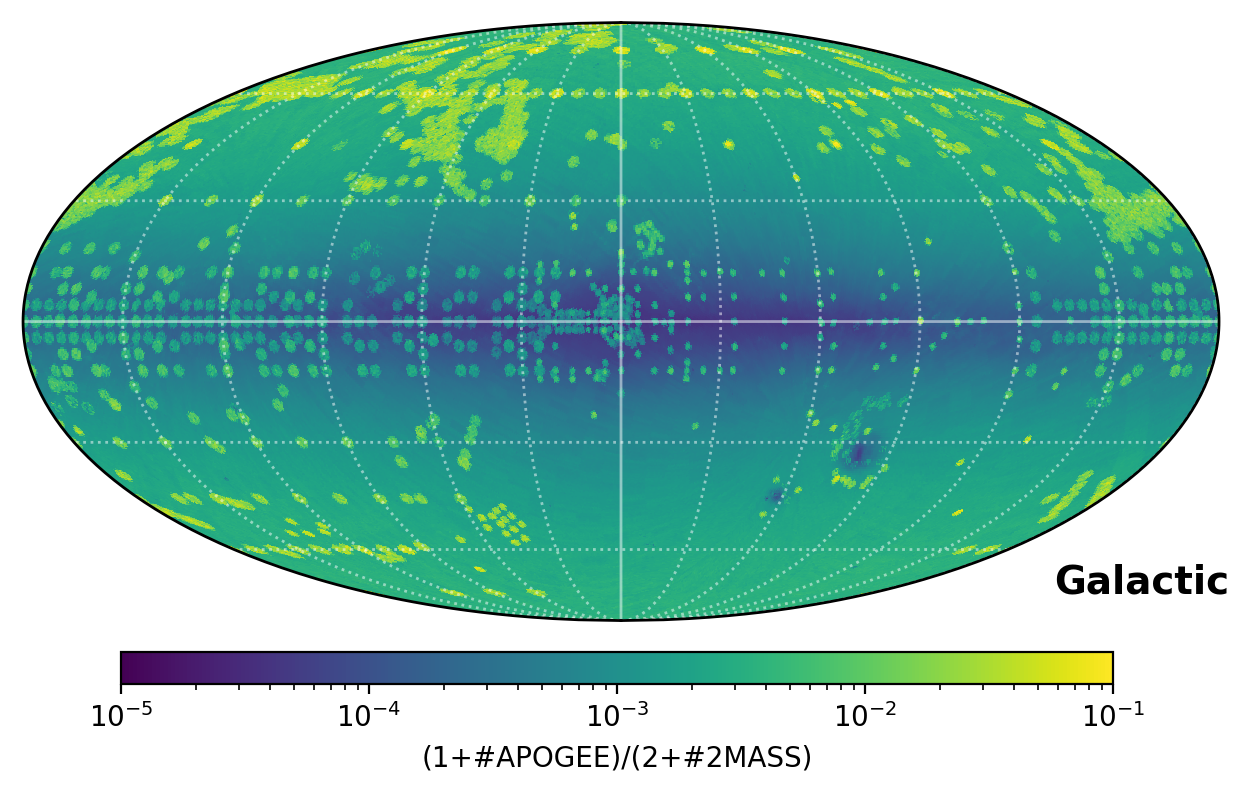

In [296]:
from matplotlib.colors import LogNorm
import matplotlib as mpl
fig = plt.figure(figsize=(8,4))
vmin,vmax = 1e-5,1e-1
cmap = plt.cm.viridis.copy()
hp.mollview((1+naive['apogee']['data'].sum(axis=0))/(naive['twomass']['data'].sum(axis=0)+2),nest=True,hold=True,coord=['C','G'],xsize=4000,min=vmin,max=vmax,cmap=cmap,norm='log',title='',cbar=False)
ax = fig.add_axes([0.2, 0.05, 0.62, 0.04])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.viridis,
                                norm=LogNorm(vmin=vmin,vmax=vmax),
                                orientation='horizontal')
cb1.set_label('(1+#APOGEE)/(2+#2MASS)')
hp.graticule(c='w',lw=1,alpha=0.5)

### Magnitude distribution

(-5.0, 25.0)

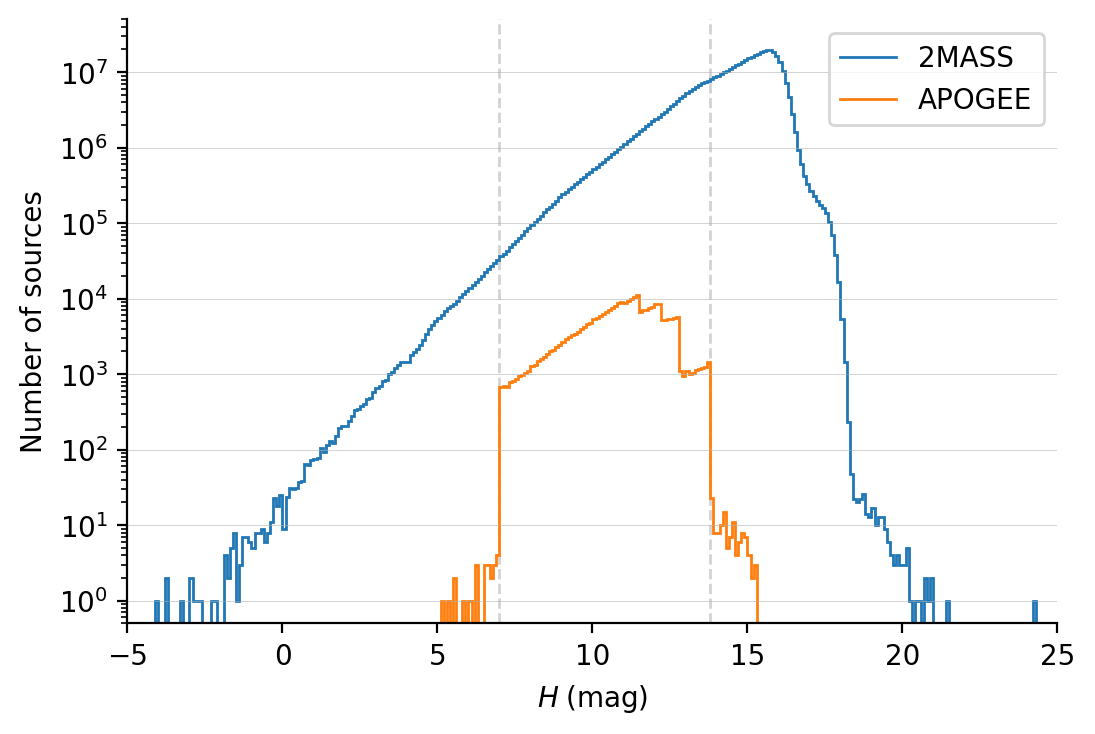

In [316]:
plt.stairs(naive['twomass']['data'].sum(axis=1),edges=Hmag_bins,label='2MASS')
plt.stairs(naive['apogee']['data'].sum(axis=1),edges=Hmag_bins,label='APOGEE')
plt.plot([7,7],[5e-1,5e7],lw=1,color='lightgrey',ls='--',zorder=0)
plt.plot([13.8,13.8],[5e-1,5e7],lw=1,color='lightgrey',ls='--',zorder=0)
plt.yscale('log')
plt.xlabel(r'$H\;(\mathrm{mag})$')
plt.ylabel(r'Number of sources')
plt.legend(frameon=True)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(which='major',lw=0.2,zorder=0,axis='y')
plt.ylim([5e-1,5e7])
plt.xlim([-5,25])

### Chisel

In [475]:
Hres, nside = 0.5, 32
M_original, P_original = naive['apogee']['data'].shape
M, P = int(300*(0.1/Hres)), hp.nside2npix(nside)
downgrade = lambda A: A.reshape(M, M_original//M, P, P_original//P).sum(axis=(1,3))
k = downgrade(naive['apogee']['data'])
n = downgrade(naive['twomass']['data'])

In [476]:
magnitude_bins

array([-5.00000000e+00, -4.00000000e+00, -3.00000000e+00, -2.00000000e+00,
       -1.00000000e+00, -1.77635684e-14,  1.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  5.00000000e+00,  6.00000000e+00,
        7.00000000e+00,  8.00000000e+00,  9.00000000e+00,  1.00000000e+01,
        1.10000000e+01,  1.20000000e+01,  1.30000000e+01,  1.40000000e+01,
        1.50000000e+01,  1.60000000e+01,  1.70000000e+01,  1.80000000e+01,
        1.90000000e+01,  2.00000000e+01,  2.10000000e+01,  2.20000000e+01,
        2.30000000e+01,  2.40000000e+01,  2.50000000e+01])

In [477]:
# Import chisel

import sys
sys.path.insert(0,'..')

from selectionfunctiontoolbox import kernel

magnitude_kernel = kernel.RationalQuadratic(lengthscale = 2.0, mixturescale = 1.0, variance = 1.0, pivot = True, pivot_tol = 1e-4)
magnitude_bins = np.linspace(Hmag_bins.min(),Hmag_bins.max(),M+1)

lmax = 64

from selectionfunctiontoolbox.hammer import Hammer

tool = Hammer(k = k,
                n = n,
                lmax = lmax,
                axes = ['magnitude','position'],
                nest = True,
                magnitude_kernel = magnitude_kernel,
                magnitude_bins = magnitude_bins,
                sparse = True,
                mu = -10,
                sigma = 1.0,
                file_root = f"naive_lmax={lmax}_Hres={Hres}_nside={nside}",
                )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/selectionfunctiontoolbox/Examples/StanModels/harmonic_magnitude_colour_position_sparse


Spherical basis file loaded
56.19% sparsity
0.00% sparsity
Incrementing lower
Incrementing pixel_to_ring
Incrementing submodes
Incrementing upper
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [478]:
%time tool.optimize(number_of_iterations=10000)

Running optimisation


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Finished optimisation, it took 3410.7 seconds
Convergence information stored in ./StanOutput/naive_lmax=64_Hres=0.5_nside=32_convergence.txt
Optimum values stored in ./StanOutput/naive_lmax=64_Hres=0.5_nside=32_results.h5
CPU times: user 4.03 s, sys: 369 ms, total: 4.4 s
Wall time: 56min 50s


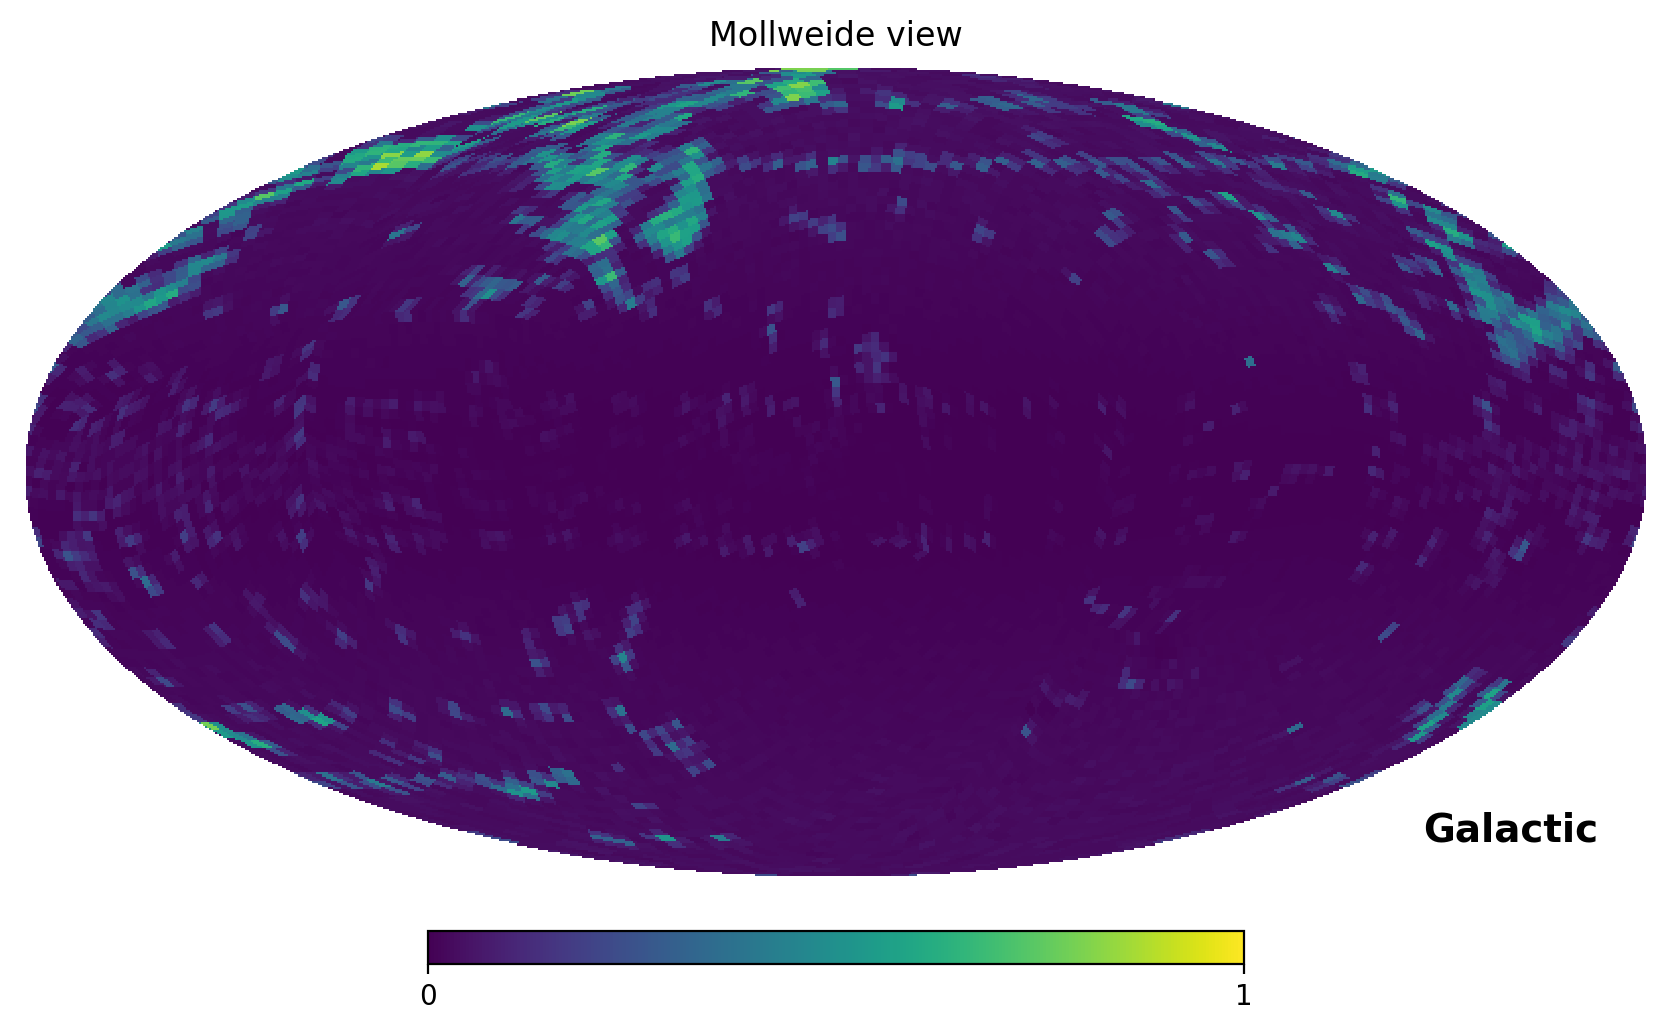

In [484]:
hp.mollview((1+k[30])/(2+n[30]),nest=True,coord=['C','G'],min=0,max=1)

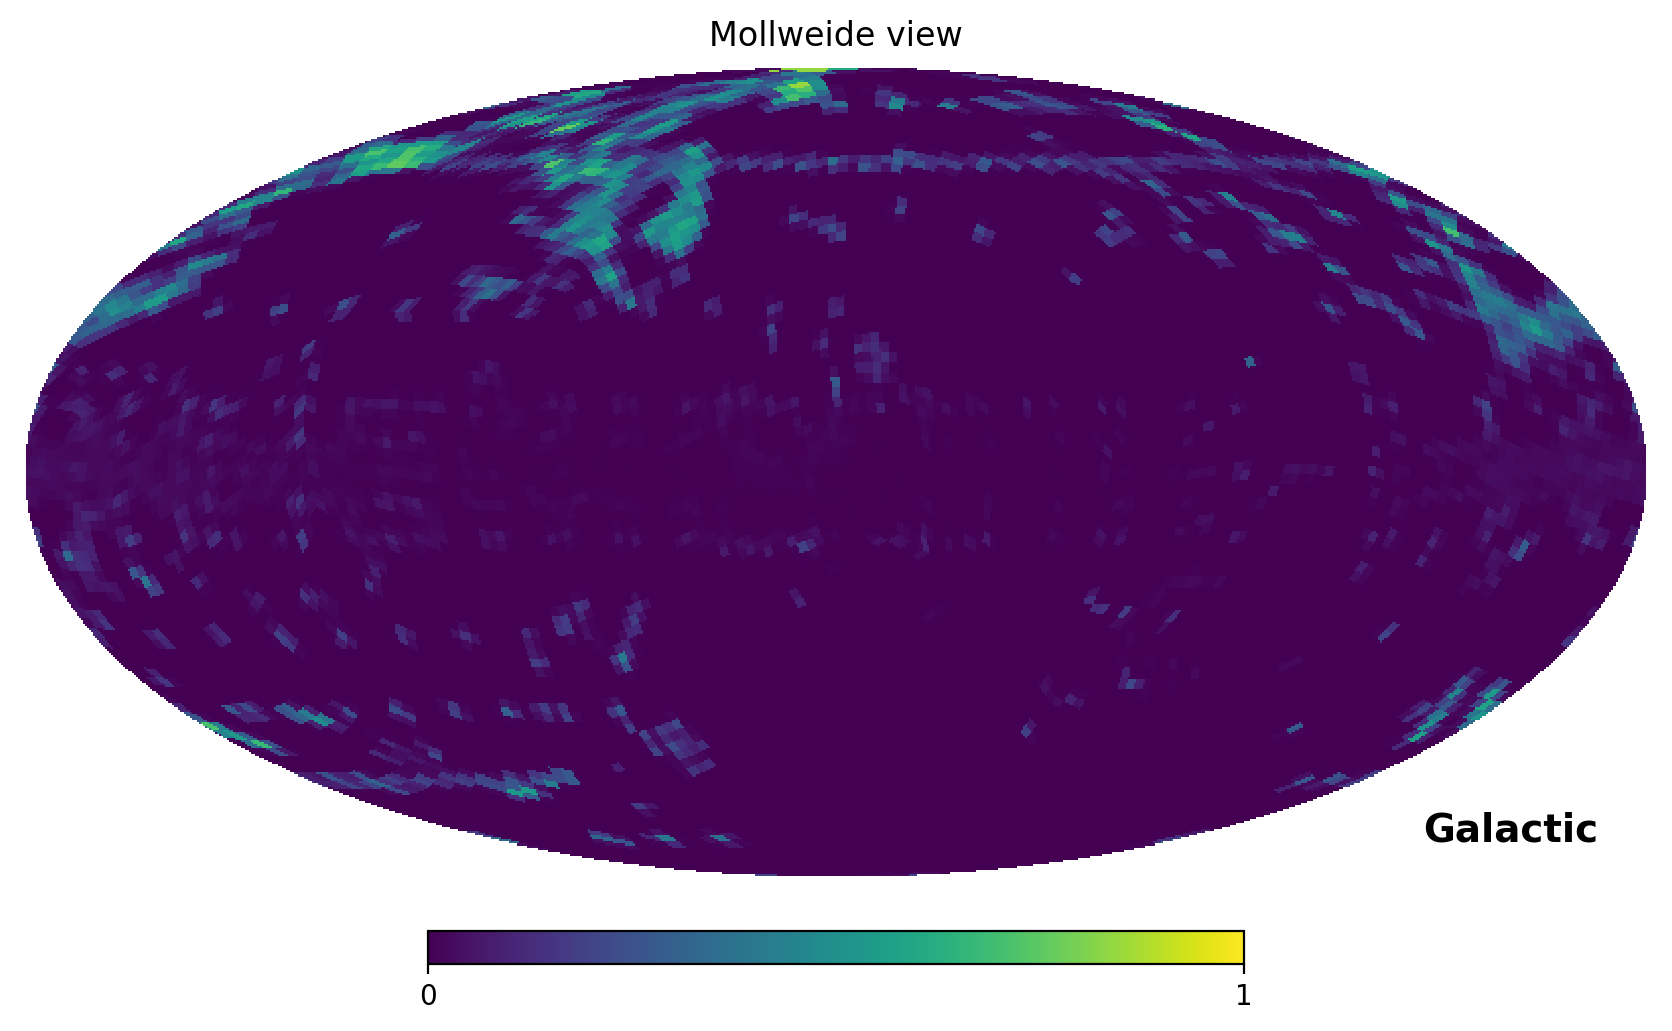

In [483]:
hp.mollview(special.expit(tool.optimum_x[30,0,:]),nest=True,coord=['C','G'],min=0,max=1)

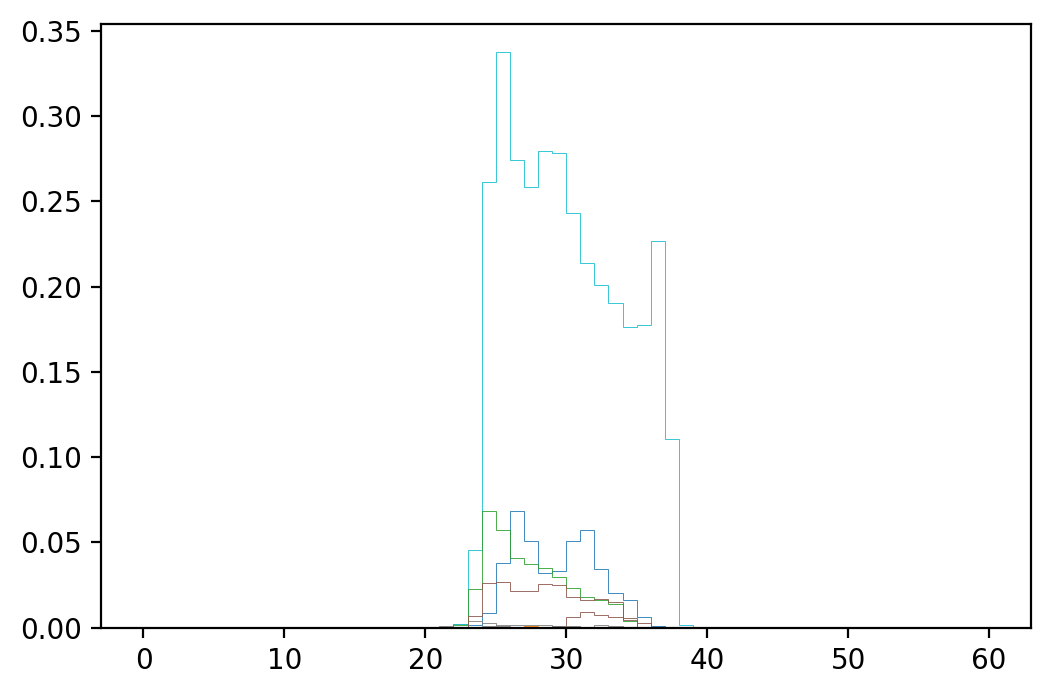

In [479]:
for p in np.random.choice(range(tool.P),20):
    plt.stairs(special.expit(tool.optimum_x[:,0,int(p)]),lw=0.3)

In [533]:
with h5py.File('./StanOutput/naive_lmax=64_Hres=0.5_nside=32_results.h5', 'r') as f:
    print(f.keys())
    naive_result = {key:f[key][:] for key in f.keys()}

<KeysViewHDF5 ['colour_bins', 'magnitude_bins', 'x', 'z']>


In [536]:
naive_result['x'].shape

(60, 1, 12288)

In [ ]:
from scipy import special
hp.mollview(special.expit(chisel.optimum_x[10,0,:]),nest=True,min=0,max=0.1,coord=['C','G'])

In [ ]:
hp.mollview((1+naive['k']['data'][:,10])/(naive['n']['data'][:,10]+2),nest=True,coord=['C','G'],min=0,max=0.1,title='',cbar=False)


# Parent

In [537]:
from astropy.table import Table, unique, vstack
apogee_fields = Table.read("https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allPlates-r12-l33.fits",format='fits')
apogee_fields = unique(apogee_fields,'LOCATION_ID')
on_field = [f"1=CONTAINS(POINT('ICRS', RAJ2000, DEJ2000),CIRCLE('ICRS', {ra}, {dec}, {radius}))" for ra,dec,radius in zip(apogee_fields['RACEN'],apogee_fields['DECCEN'],apogee_fields['RADIUS'])]

In [538]:
import astropy.units as u
import astropy.coordinates as coord
import networkx as nx
fields = coord.SkyCoord(ra=apogee_fields['RACEN']*u.degree, dec=apogee_fields['DECCEN']*u.degree)

G = nx.Graph()
for field1, field2, dist, _ in zip(*coord.search_around_sky(fields,fields,seplimit=3.0*u.degree)):
    if apogee_fields['RADIUS'][field1] + apogee_fields['RADIUS'][field2] > dist.deg:
        G.add_edge(field1, field2)
        
connected_regions = [list(l) for l in nx.connected_components(G)]

/Users/douglasboubert/anaconda3/envs/cmdstan/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1441 [00:00<?, ?it/s]

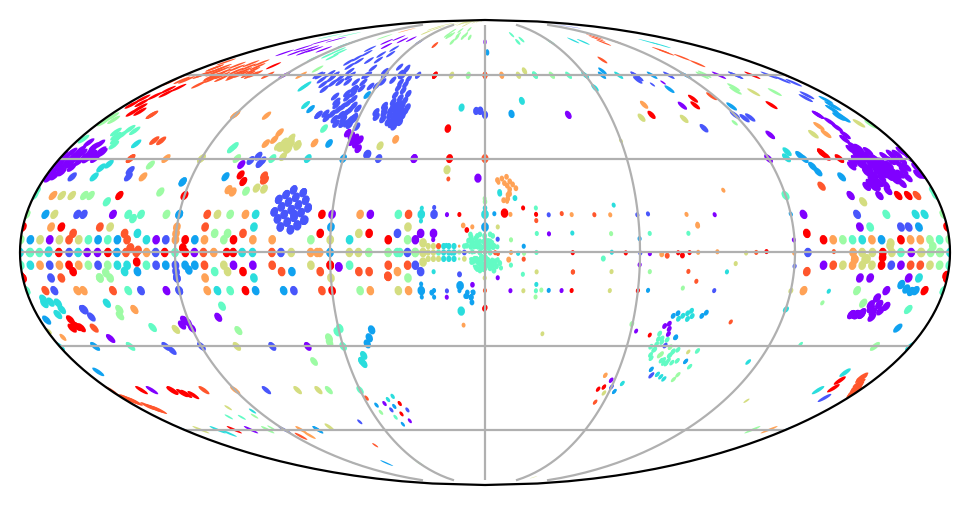

In [539]:
region_color = np.zeros((len(apogee_fields),4))
for i,l in enumerate(connected_regions):
    for j in l:
        region_color[j] = plt.cm.rainbow((i%10)/9)
        
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

import astropy.coordinates as coord
import astropy.units as u
fields = coord.SkyCoord(ra=apogee_fields['RACEN']*u.degree, dec=apogee_fields['DECCEN']*u.degree)
apogee_fields['GLON'], apogee_fields['GLAT'] = -fields.galactic.l.deg, fields.galactic.b.deg


ax = plt.axes(projection=ccrs.Mollweide())

#ax.stock_img()
ax.set_global()
ax.gridlines(lw=1)
for i in tqdm.tqdm_notebook(range(N_field)):
    patch = Circle((apogee_fields['GLON'][i], apogee_fields['GLAT'][i]), apogee_fields['RADIUS'][i], lw = 0, color=region_color[i], transform=ccrs.Geodetic())
    ax.add_patch(patch)
plt.savefig('./ExampleResults/apogee_fields.pdf',dpi=300,bbox_inches='tight')
plt.savefig('./ExampleResults/apogee_fields.png',dpi=300,bbox_inches='tight',facecolor='white')

In [540]:
#%%time
from astropy.table import Table
import healpy
#import warnings
#warnings.filterwarnings("ignore")
from astropy import log
import time
#log.disable_warnings_logging()
log.setLevel('ERROR')

healpix_order = 7
healpix_nside = hp.order2nside(healpix_order)
healpix_npix = hp.nside2npix(healpix_nside)
healpix_bins = np.arange(-0.5,healpix_npix)
Hmag_resolution = 0.1
Hmag_bins = np.arange(7.0,13.8+1e-9,Hmag_resolution)
N_Hmag = Hmag_bins.size-1
N_healpix = healpix_bins.size-1

filename = './ExampleData/parent.h5'
parent = {'apogee':{'vizier':'III/284/allstars','filename':'parent_apogee','identifier':'Target','where':'AND EFlag=0 AND Hmag>7.0 AND Hmag<13.8'},
          'twomass':{'vizier':'II/246/out','filename':'parent_twomass','identifier':'2MASS','where':'AND Hmag>7.0 AND Hmag<13.8'}}

for key in parent.keys():
    try:
        with h5py.File(filename, 'r') as f:
            parent[key]['data'] = f[key][:]
            
    except (KeyError, OSError):
        from astroquery.utils.tap.core import TapPlus   
        tap = TapPlus(url="http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap",verbose=False)
        
        parent[key]['data'] = np.zeros((N_Hmag,N_healpix),dtype=int)
        for region in tqdm.tqdm_notebook(connected_regions):
            field_tables = []
            for field in region:
                query = f'''SELECT identifier, healpix_index AS healpix, Hmag_index * {Hmag_resolution} AS Hmag FROM (
                SELECT {parent[key]['identifier']} as identifier,
                    IVO_HEALPIX_INDEX({healpix_order}, RAJ2000, DEJ2000) AS healpix_index,
                    floor(Hmag / {Hmag_resolution}) AS Hmag_index
                FROM "{parent[key]['vizier']}"
                WHERE 1=CONTAINS(POINT('ICRS', RAJ2000, DEJ2000),CIRCLE('ICRS', {apogee_fields['RACEN'][field]}, {apogee_fields['DECCEN'][field]}, {apogee_fields['RADIUS'][field]}))
                {parent[key]['where']}
                ) AS subquery'''
                downloaded = False
                while downloaded == False:
                    try:
                        job = tap.launch_job_async(query)
                        field_tables.append(job.get_results())
                        downloaded = True
                    except HTTPError:
                        time.sleep(1)
            try:
                # Concatenate and drop duplicates
                region_table = unique(vstack(field_tables),'identifier')
                
                # Add to histogram
                parent[key]['data'] += np.histogram2d(region_table['Hmag'],region_table['healpix'],bins=(Hmag_bins,healpix_bins))[0].astype(int)
            except IndexError:
                # No stars
                continue
           
        with h5py.File(filename, 'a') as f:
            f.create_dataset(key,data=parent[key]['data'])
        

In [541]:
Hmag_bins.shape

(69,)

In [573]:
Hres, nside = 0.4, 32
M_original, P_original = parent['apogee']['data'].shape
M, P = int(68*(0.1/Hres)), hp.nside2npix(nside)
downgrade = lambda A: A.reshape(M, M_original//M, P, P_original//P).sum(axis=(1,3))
k = downgrade(parent['apogee']['data'])
n = downgrade(parent['twomass']['data'])

In [587]:
from selectionfunctiontoolbox import kernel

magnitude_kernel = kernel.RationalQuadratic(lengthscale = 2.0, mixturescale = 1.0, variance = 1.0, pivot = True, pivot_tol = 1e-4)
magnitude_bins = np.linspace(Hmag_bins.min(),Hmag_bins.max(),M+1)

# Import chisel
from selectionfunctiontoolbox.chisel import Chisel

tool = Chisel(k = k,
                n = n,
                j = [-1,0,1,2,3,4,5],
                B = 2.0,
                wavelet_tol = 1e-4,
                needlet = 'chisquare',
                axes = ['magnitude','position'],
                nest = True,
                magnitude_kernel = magnitude_kernel,
                magnitude_bins = magnitude_bins,
                sparse = True,
                mu = -10.0,
                sigma = 1.0,
                file_root = f"parent",
                )


Spherical basis file does not exist, generating... (this may take some time!)
Working on order -1.
Working on order 0.
100%|██████████| 12/12 [00:00<00:00, 32.09it/s]
Working on order 1.
100%|██████████| 48/48 [00:00<00:00, 1183.38it/s]
Working on order 2.
100%|██████████| 192/192 [00:00<00:00, 974.06it/s]
Working on order 3.
100%|██████████| 768/768 [00:01<00:00, 607.58it/s]
Working on order 4.
100%|██████████| 3072/3072 [00:08<00:00, 362.77it/s]
Working on order 5.
100%|██████████| 12288/12288 [01:10<00:00, 174.54it/s]
Expanding u


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/selectionfunctiontoolbox/Examples/StanModels/wavelet_magnitude_colour_position_sparse


Spherical basis file loaded
32.35% sparsity
0.00% sparsity
Incrementing wavelet_U
Incrementing wavelet_u
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [588]:
%time tool.optimize(number_of_iterations=10000)

Running optimisation


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Finished optimisation, it took 2489.8 seconds
Convergence information stored in ./StanOutput/parent_convergence.txt
Optimum values stored in ./StanOutput/parent_results.h5
CPU times: user 12.6 s, sys: 1.89 s, total: 14.5 s
Wall time: 41min 30s


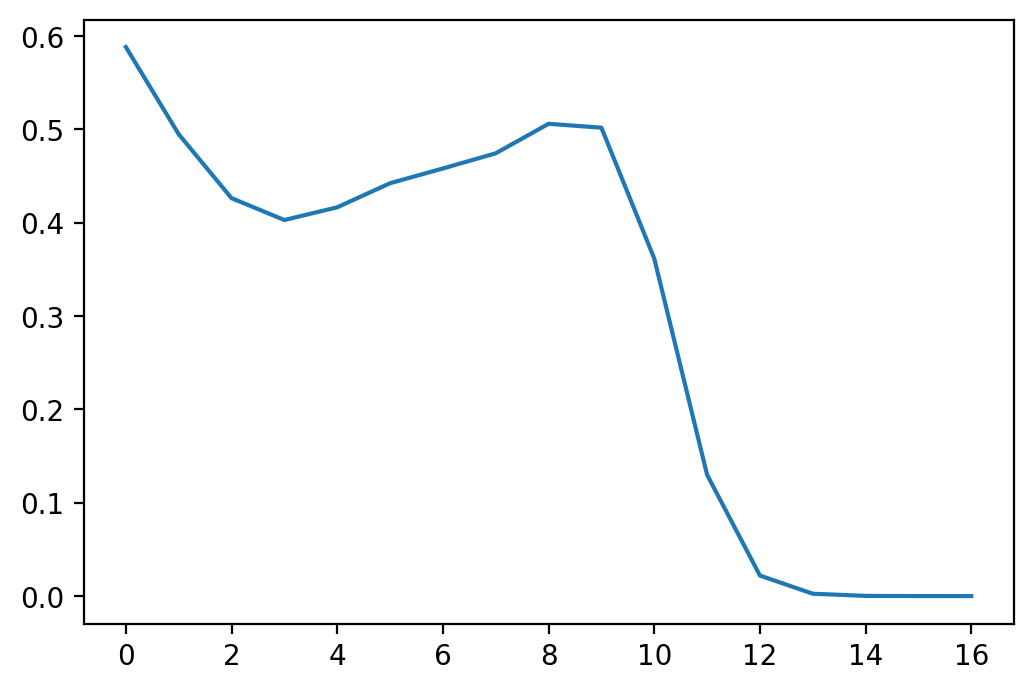

In [584]:
plt.plot(special.expit(tool.optimum_x[:,0,2]))

/Users/douglasboubert/anaconda3/envs/cmdstan/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/douglasboubert/anaconda3/envs/cmdstan/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/douglasboubert/anaconda3/envs/cmdstan/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: Y

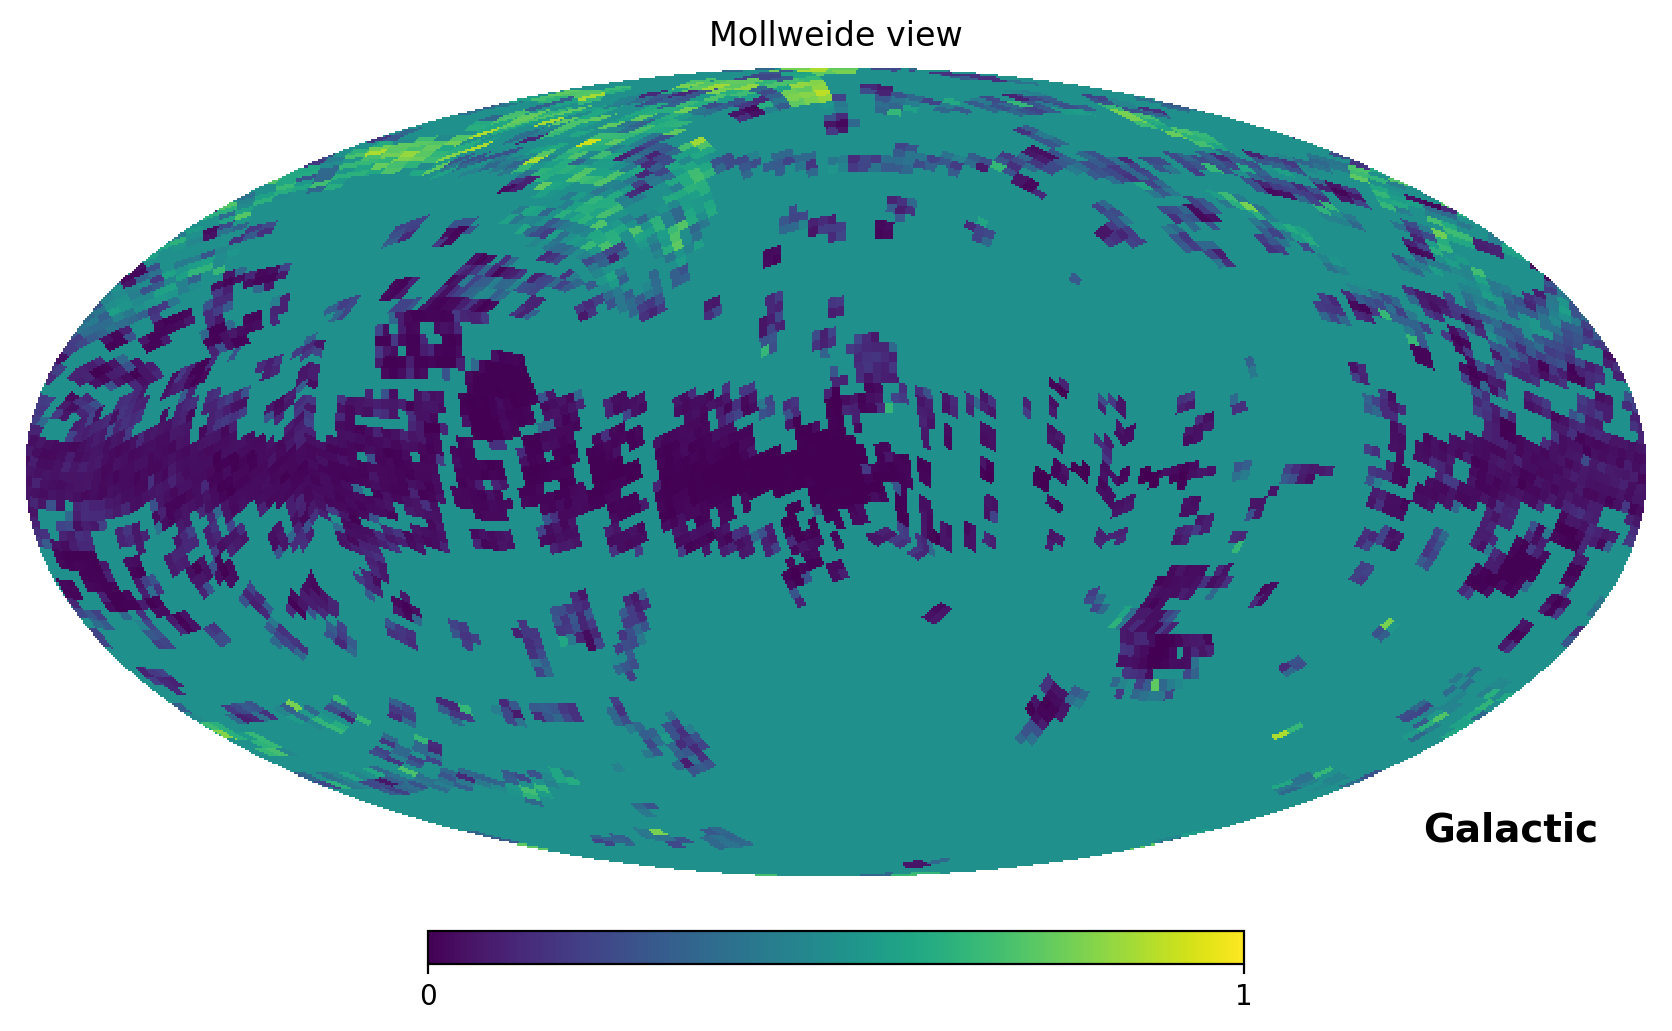

In [585]:
hp.mollview((1+k[10])/(2+n[10]),nest=True,coord=['C','G'],min=0,max=1)

/Users/douglasboubert/anaconda3/envs/cmdstan/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/douglasboubert/anaconda3/envs/cmdstan/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/douglasboubert/anaconda3/envs/cmdstan/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: Y

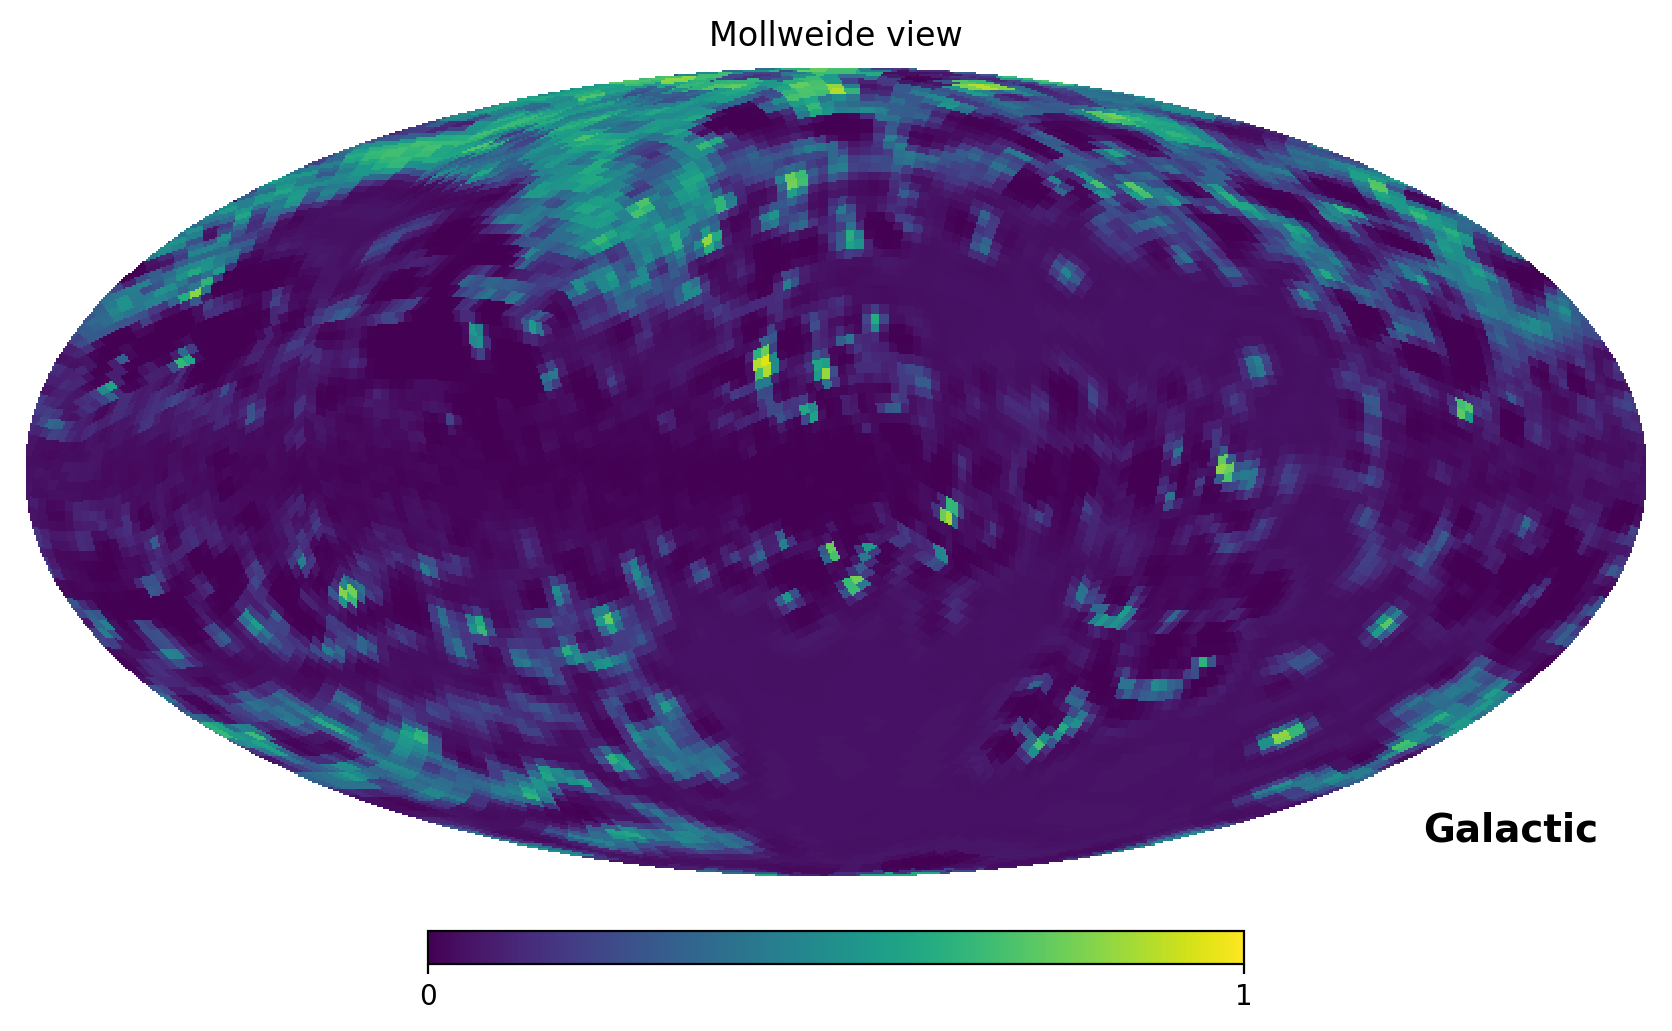

In [589]:
hp.mollview(special.expit(tool.optimum_x[10,0,:]),nest=True,coord=['C','G'],min=0,max=1)

# Basic

In [485]:
from astropy.table import Table, unique, vstack
apogee_fields = Table.read("https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allPlates-r12-l33.fits",format='fits')
apogee_fields = unique(apogee_fields,'LOCATION_ID')


In [ ]:
from astropy import units
from healpy.projector import MollweideProj
from healpy import Rotator

# Obtain (longitude, latitude) pairs of HEALPix pixels
#hp = HEALPix(nside=64, order='nested')
number_of_steps_per_circle = 100
longitude, latitude = (angles.to(units.deg).value for angles in hp.boundaries_lonlat(range(hp.npix), step=number_of_steps_per_side))



In [ ]:
apogee_fields['RADIUS'][i]

In [ ]:
longitude

In [ ]:
plt.plot(x[i],y[i])

In [ ]:
fig = plt.figure(figsize=(8,6))
hp.graticule(dpar=360,dmer=180)
l = np.linspace(-180,180,10)
for ra,dec,radius in zip(tqdm.tqdm_notebook(apogee_fields['RACEN'][:100]),apogee_fields['DECCEN'][:100],apogee_fields['RADIUS'][:100]):
    hp.projplot(l,-90+radius*np.ones(10),lonlat=True,coord='G',c='lightgrey',rot=[ra-180,-dec,0],lw=0.5)


In [ ]:
# Rotate from Equatorial to Galactic
R = Rotator(coord=['C','G'])
for i in tqdm.tqdm_notebook(range(hp.npix)):
    longitude[i], latitude[i] = R(longitude[i], latitude[i],lonlat=True)

# Project to Mollweide
projector = MollweideProj()
x, y = np.zeros_like(longitude), np.zeros_like(latitude)
for i in tqdm.notebook.tqdm(range(hp.npix)):
    x[i], y[i] = projector.ang2xy(theta=longitude[i],phi=latitude[i],lonlat=True)

In [486]:
%%time
from astropy.table import Table
import healpy
import time
from requests.exceptions import HTTPError
from astropy import log
log.setLevel('ERROR')

Hmag_resolution = 0.1
Hmag_bins = np.arange(7.0,13.8+1e-9,Hmag_resolution)
JKmag_resolution = 0.1
JKmag_bins = np.arange(-1.0,10.0+1e-9,JKmag_resolution)
N_Hmag = Hmag_bins.size-1
N_JKmag = JKmag_bins.size-1
N_field = len(apogee_fields)

filename = './ExampleData/cmd.h5'

cmd = {'apogee':{'vizier':'III/284/allstars','Kmag':'Ksmag','where':'AND EFlag=0 AND Hmag>7.0 AND Hmag<13.8'},
          'twomass':{'vizier':'II/246/out','Kmag':'Kmag','where':'AND Hmag>7.0 AND Hmag<13.8'}}

for key in cmd.keys():
    try:
        with h5py.File(filename, 'r') as f:
            cmd[key]['data'] = f[key][:]
            
    except (KeyError, OSError):
        from astroquery.utils.tap.core import TapPlus   
        tap = TapPlus(url="http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap",verbose=False)
        
        cmd[key]['data'] = np.zeros((N_Hmag,N_JKmag,N_field),dtype=int)
        for field in tqdm.tqdm_notebook(range(N_field)):
            
            verify_field = f"AND Loc = {apogee_fields['LOCATION_ID'][field]}" if key == 'apogee' else ''
            
            query = f'''SELECT Hmag_index * {Hmag_resolution} AS Hmag, JKmag_index * {JKmag_resolution} AS JKmag, count(*) AS frequency FROM (
                        SELECT floor(Hmag / {Hmag_resolution}) AS Hmag_index,
                               floor((Jmag - {cmd[key]['Kmag']}) / {JKmag_resolution}) AS JKmag_index
                        FROM "{cmd[key]['vizier']}"
                        WHERE 1=CONTAINS(POINT('ICRS', RAJ2000, DEJ2000),CIRCLE('ICRS', {apogee_fields['RACEN'][field]}, {apogee_fields['DECCEN'][field]}, {apogee_fields['RADIUS'][field]}))
                        {cmd[key]['where']}
                        {verify_field}
                        ) AS subquery
                        GROUP BY Hmag_index, JKmag_index'''

            downloaded = False
            while downloaded == False:
                try:
                    job = tap.launch_job_async(query)
                    result = job.get_results()
                    downloaded = True
                except HTTPError:
                    time.sleep(1)
                    
            cmd[key]['data'][:,:,field] = np.histogram2d(result['Hmag'],result['JKmag'],bins=(Hmag_bins,JKmag_bins),weights=result['frequency'])[0].astype(int)
        
        with h5py.File(filename, 'a') as f:
            f.create_dataset(key,data=cmd[key]['data'])

CPU times: user 3.76 ms, sys: 127 ms, total: 131 ms
Wall time: 878 ms


In [519]:
# Import wrench
import sys
sys.path.insert(0,'..')

from selectionfunctiontoolbox import kernel
from selectionfunctiontoolbox.wrench import Wrench

magnitude_kernel = kernel.RationalQuadratic(lengthscale = 3.0, mixturescale = 0.3, variance = 1.0, pivot = True, pivot_tol = 1e-4)

wrench = Wrench(k = cmd['apogee']['data'][:,:,:1].sum(axis=(1),keepdims=True),
                n = cmd['twomass']['data'][:,:,:1].sum(axis=(1),keepdims=True),
                axes = ['magnitude','colour','position'],
                sparse = True,
                magnitude_kernel = magnitude_kernel,
                mu = -5,
                sigma = 1,
                file_root = "basic",
                )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/selectionfunctiontoolbox/Examples/StanModels/basic_magnitude_colour_position_sparse


Spherical basis file loaded
7.84% sparsity
0.00% sparsity
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [520]:
wrench.M_subspace

3

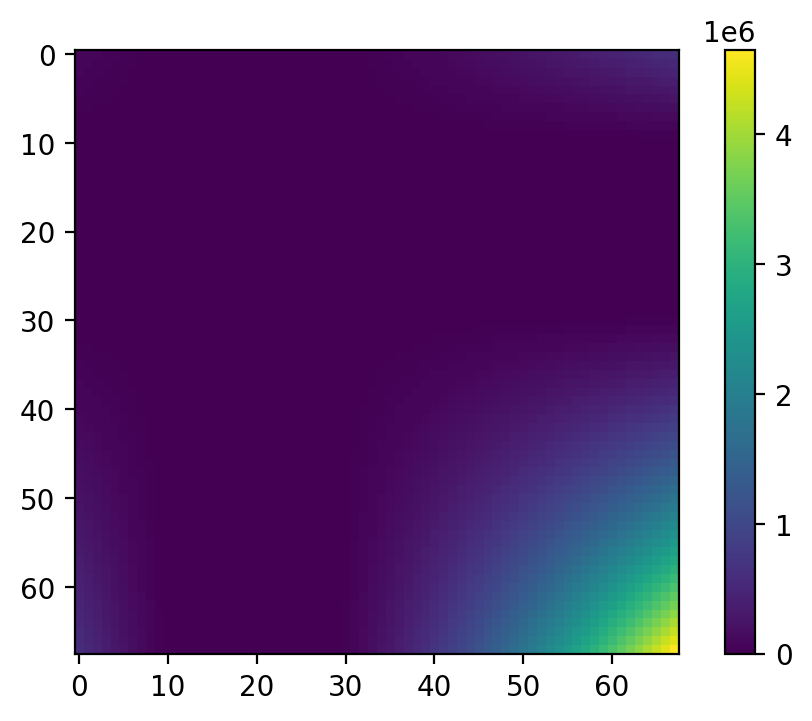

In [521]:
plt.imshow(np.dot(wrench.cholesky_m,wrench.cholesky_m.T),vmin=0)
plt.colorbar()

In [522]:
%time wrench.optimize(number_of_iterations=10000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Running optimisation
Finished optimisation, it took 0.0 seconds
Convergence information stored in ./StanOutput/basic_convergence.txt
Optimum values stored in ./StanOutput/basic_results.h5
CPU times: user 13.9 ms, sys: 24 ms, total: 37.9 ms
Wall time: 58.2 ms


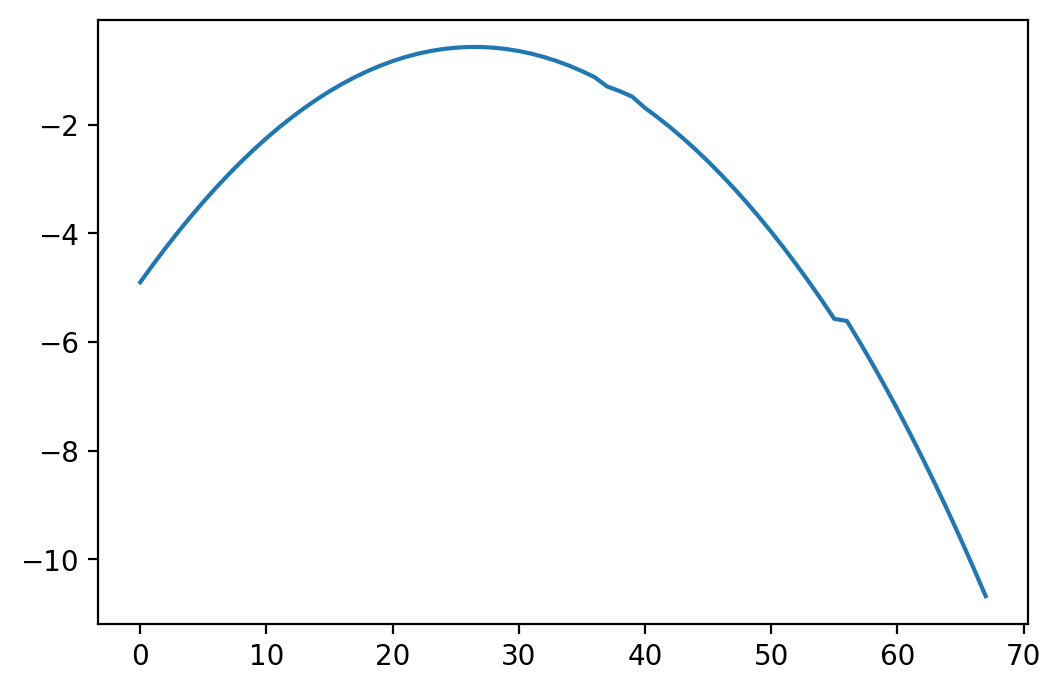

In [523]:
plt.plot(wrench.optimum_x[:,0,0])

In [141]:
special.expit(-5)*300

2.0078552772854565

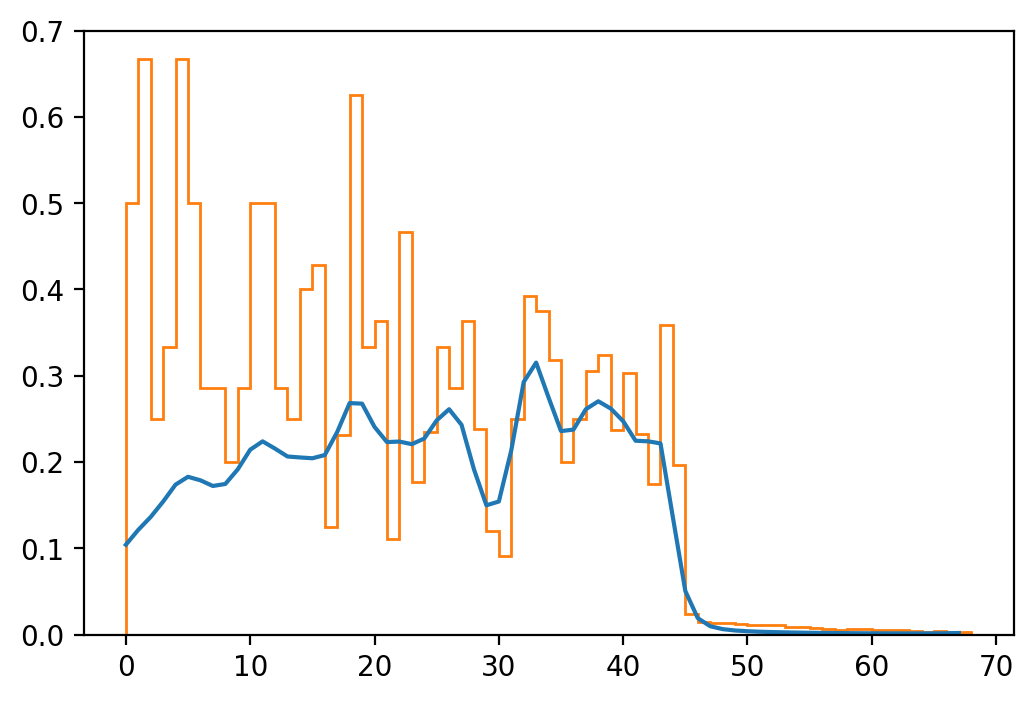

In [285]:
plt.plot(special.expit(wrench.optimum_x[:,0,0]))
plt.stairs((wrench.k[:,0,0]+1)/(wrench.n[:,0,0]+2))
#plt.stairs(wrench.k[:,0,0]/10)
#plt.stairs(wrench.n[:,0,0])

In [ ]:
wrench.k[:,0,0]

In [ ]:
plt.plot(special.expit(wrench.optimum_x[:,0,0]))

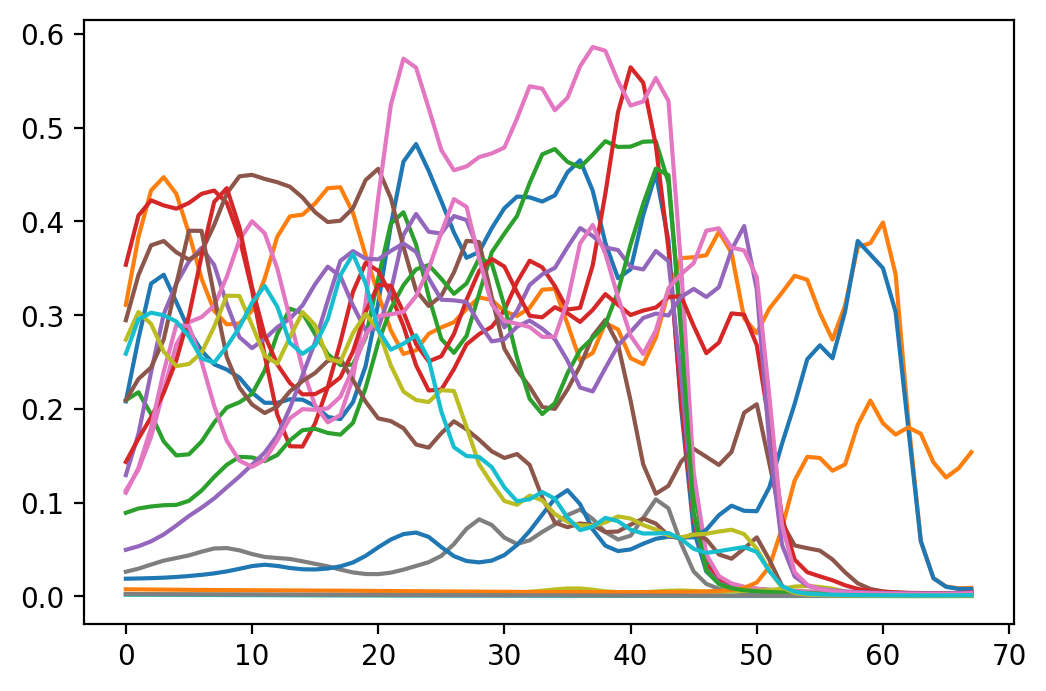

In [284]:
for i in np.random.choice(1200,20):
    plt.plot(special.expit(wrench.optimum_x[:,0,i]))

In [ ]:
from scipy import special
plt.imshow(special.expit(wrench.optimum_x[:,:,9]),vmin=0,vmax=1,cmap='RdBu_r')

In [ ]:
fig,axes = plt.subplots(3,1,figsize=(10,10))
cmap = plt.cm.viridis
cmap.set_under('w')
axes[0].imshow(cmd['twomass']['data'][:,:,9],vmin=1,cmap=cmap)
axes[1].imshow(cmd['apogee']['data'][:,:,9],vmin=1,cmap=cmap)
axes[2].imshow(np.random.binomial(n=cmd['twomass']['data'][:,:,4],p=special.expit(wrench.optimum_x[:,:,9])),vmin=1,cmap=cmap)

In [ ]:
plt.imshow(cmd['twomass']['data'][:,:,0]-cmd['apogee']['data'][:,:,0],vmin=-5,vmax=5,cmap='RdBu_r')

In [ ]:
fig = plt.figure(figsize=(8,6))
hp.graticule(dpar=360,dmer=180)
l = np.linspace(-180,180,10)
for ra,dec,radius in zip(tqdm.tqdm_notebook(apogee_plates['RACEN'][:300]),apogee_plates['DECCEN'][:300],apogee_plates['RADIUS'][:300]):
    hp.projplot(l,-90+radius*np.ones(10),lonlat=True,coord='G',c='lightgrey',rot=[ra-180,-dec,0],lw=0.5)
